In [1]:
import os
import numpy as np
#import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from emnist import list_datasets, extract_training_samples, extract_test_samples

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def flatten(data, dim_img = (28, 28)):
    return data.reshape(len(data), dim_img[0] * dim_img[1])
    
print(list_datasets())

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']


In [2]:
tipus = "balanced"

X_full_train, y_full_train = extract_training_samples(tipus)
X_test, y_test = extract_test_samples(tipus)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size = 0.1, random_state = 123)

X_train_red, y_train_red = flatten(X_train[:10000]), y_train[:10000]

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95) # Les variables son centrades automaticament
X_train_PCA = pca.fit_transform(flatten(X_train))
X_val_PCA = pca.transform(flatten(X_val))
X_train_PCA_red = X_train_PCA[:10000]

In [103]:
import time

def model_fit_eval(model, X, y, X_val, y_val):
    t0 = time.time()
    model.fit(X, y)
    t1 = time.time()
    fit_time = t1 - t0
    print("Accuracy train = {:.2f} % (Train: {:.1f} seconds)".format(model.score(X, y) * 100, fit_time))
    t0 = time.time()
    print("Accuracy val = {:.2f} %".format(model.score(X_val, y_val) * 100), end = " ")
    t1 = time.time()
    pred_time = t1 - t0
    print("(Pred: {:.1f} seconds)".format(pred_time))
    return model

# Regressió multinomial

In [114]:
from sklearn.linear_model import LogisticRegression
X_train_PCA_red, y_train_red = X_train_PCA[:10000], y_train[:10000]

multinomial_model_PCA = make_pipeline(StandardScaler(), 
                             LogisticRegression(multi_class = 'multinomial', max_iter = 500, tol = 1e-3, solver = "lbfgs"))
multinomial_model_PCA = model_fit_eval(multinomial_model_PCA, X_train_PCA_red, y_train_red, X_val_PCA, y_val)

Accuracy train = 77.02 % (Train: 5.6 seconds)
Accuracy val = 63.80 % (Pred: 0.0 seconds)


# Lineal SVM

## Amb PCA SGD

In [106]:
from sklearn.linear_model import SGDClassifier
X_train_PCA_red, y_train_red = X_train_PCA[:10000], y_train[:10000]

sgd_model_PCA = make_pipeline(StandardScaler(), 
                    SGDClassifier(loss = 'hinge', alpha = 0.0001, max_iter = 500, tol = 5e-3, random_state = 123))
sgd_model_PCA = model_fit_eval(sgd_model_PCA, X_train_PCA_red, y_train_red, X_val_PCA, y_val)

Accuracy train = 70.37 % (Train: 5.4 seconds)
Accuracy val = 56.69 % (Pred: 0.0 seconds)


## Sense PCA SGD

In [107]:
X_train_red, y_train_red = flatten(X_train[:10000]), y_train[:10000]

sgd_model = make_pipeline(StandardScaler(), 
                    SGDClassifier(loss = 'hinge', alpha = 0.0001, max_iter = 500, tol = 5e-3, random_state = 123))
sgd_model.fit(X_train_red, y_train_red)
sgd_model = model_fit_eval(sgd_model, X_train_red, y_train_red, flatten(X_val), y_val)

Accuracy train = 73.25 % (Train: 41.2 seconds)
Accuracy val = 61.80 % (Pred: 0.1 seconds)


# SVC 

## Amb PCA

In [108]:
from sklearn.svm import SVC
X_train_PCA_red, y_train_red = X_train_PCA[:5000], y_train[:5000]

SVC_model_PCA = make_pipeline(StandardScaler(), 
                    SVC(kernel = 'rbf', gamma = 'scale', C = 1, max_iter = 500, tol = 1e-3, random_state = 123))
SVC_model_PCA = model_fit_eval(SVC_model_PCA, X_train_PCA_red, y_train_red, X_val_PCA, y_val)

Accuracy train = 94.54 % (Train: 2.9 seconds)
Accuracy val = 64.78 % (Pred: 12.1 seconds)


## Sense PCA

In [110]:
X_train_red, y_train_red = flatten(X_train[:5000]), y_train[:5000]
SVC_model = make_pipeline(StandardScaler(), 
                    SVC(kernel = 'rbf', gamma = 'scale', C = 1, max_iter = 500, tol = 1e-3, random_state = 123))
SVC_model = model_fit_eval(SVC_model, X_train_red, y_train_red, flatten(X_val), y_val)

Accuracy train = 89.42 % (Train: 4.8 seconds)
Accuracy val = 68.85 % (Pred: 39.6 seconds)


# Random Forest

## Amb PCA

In [111]:
from sklearn.ensemble import RandomForestClassifier
X_train_PCA_red, y_train_red = X_train_PCA[:10000], y_train[:10000]

forest_model_PCA = RandomForestClassifier(n_estimators = 100, random_state = 123) # Per regularitzar: max_depth  
forest_model_PCA = model_fit_eval(forest_model_PCA, X_train_PCA_red, y_train_red, X_val_PCA, y_val)

Accuracy train = 100.00 % (Train: 14.4 seconds)
Accuracy val = 66.16 % (Pred: 0.7 seconds)


## Sense PCA

In [112]:
X_train_red, y_train_red = flatten(X_train[:10000]), y_train[:10000]

forest_model = RandomForestClassifier(n_estimators = 100, random_state = 123)
forest_model = model_fit_eval(forest_model, X_train_red, y_train_red, flatten(X_val), y_val)

Accuracy train = 100.00 % (Train: 9.5 seconds)
Accuracy val = 72.31 % (Pred: 0.7 seconds)


# ANN

Parametres a modificar: 

1. learning rate (al canviar qualsevol hyperparametre, tornar a learning rate)
2. optimizer 
3. nombre capes
4. neurones per capa
5. funcions d'activació per capa
6. batch size (fit(batch_size = x))

## Sense PCA

In [3]:
import tensorflow as tf
from tensorflow import keras

In [147]:
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [148]:
k = len(np.unique(y_train))
nn_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(400, activation = "relu"),
    keras.layers.Dense(200, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(k, activation = "softmax")
])
nn_model.compile(loss = "sparse_categorical_crossentropy", # keras.losses.sparse_categorical_crossentropy
              optimizer = keras.optimizers.SGD(),
              metrics = ["accuracy"])

history = nn_model.fit(X_train / 255, y_train, epochs = 5, validation_data = (X_val / 255, y_val))
#model.evaluate(X_test, y_test) # al final de tot, no ara

Epoch 1/5
3173/3173 [==============================] - 18s 5ms/step - loss: 1.9255 - accuracy: 0.4939 - val_loss: 1.1551 - val_accuracy: 0.6680
Epoch 2/5
3173/3173 [==============================] - 12s 4ms/step - loss: 1.0191 - accuracy: 0.7035 - val_loss: 0.8808 - val_accuracy: 0.7376
Epoch 3/5
3173/3173 [==============================] - 11s 3ms/step - loss: 0.8085 - accuracy: 0.7568 - val_loss: 0.7495 - val_accuracy: 0.7692
Epoch 4/5
3173/3173 [==============================] - 12s 4ms/step - loss: 0.6933 - accuracy: 0.7851 - val_loss: 0.6930 - val_accuracy: 0.7810
Epoch 5/5
3173/3173 [==============================] - 17s 5ms/step - loss: 0.6206 - accuracy: 0.8032 - val_loss: 0.6243 - val_accuracy: 0.8019


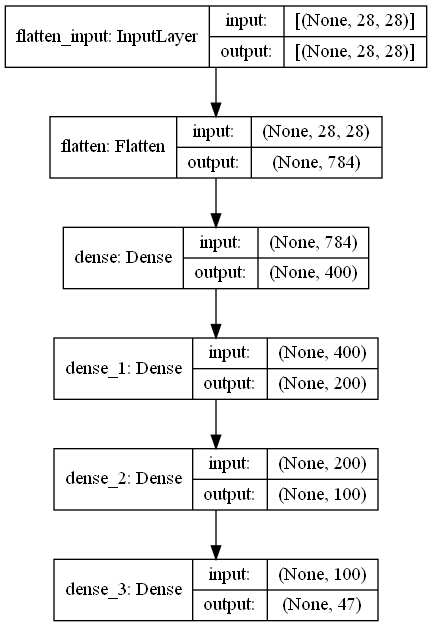

In [149]:
keras.utils.plot_model(nn_model, "nn_estructure.png", show_shapes = True)

## Amb PCA

In [4]:
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
scaler = MinMaxScaler()
X_train_PCA_N = scaler.fit_transform(X_train_PCA)
X_val_PCA_N = scaler.fit_transform(X_val_PCA)

In [129]:
k = len(np.unique(y_train))
nn_model_PCA = keras.models.Sequential([
    keras.layers.InputLayer(input_shape = X_train_PCA.shape[1:]),
    keras.layers.Dense(400, activation = "relu"),
    keras.layers.Dense(200, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(k, activation = "softmax")
])
nn_model_PCA.compile(loss = "sparse_categorical_crossentropy", # keras.losses.sparse_categorical_crossentropy
              optimizer = keras.optimizers.SGD(),
              metrics = ["accuracy"])


history = nn_model_PCA.fit(X_train_PCA_N, y_train, epochs = 5, validation_data = (X_val_PCA_N, y_val))

Epoch 1/5
3173/3173 [==============================] - 4s 1ms/step - loss: 3.7996 - accuracy: 0.0839 - val_loss: 3.7077 - val_accuracy: 0.1303
Epoch 2/5
3173/3173 [==============================] - 4s 1ms/step - loss: 3.1794 - accuracy: 0.2293 - val_loss: 2.4980 - val_accuracy: 0.3303
Epoch 3/5
3173/3173 [==============================] - 4s 1ms/step - loss: 2.1026 - accuracy: 0.4286 - val_loss: 1.8080 - val_accuracy: 0.4907
Epoch 4/5
3173/3173 [==============================] - 4s 1ms/step - loss: 1.6295 - accuracy: 0.5421 - val_loss: 1.5746 - val_accuracy: 0.5497
Epoch 5/5
3173/3173 [==============================] - 4s 1ms/step - loss: 1.4278 - accuracy: 0.5934 - val_loss: 1.5090 - val_accuracy: 0.5541


# CNN

In [6]:
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [7]:
X_train = X_train[..., np.newaxis] / 255
X_val = X_val[..., np.newaxis] / 255
X_test = X_test[..., np.newaxis] / 255

In [8]:
k = len(np.unique(y_train))
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size = 3, padding = "same", activation = "relu"),
    keras.layers.Conv2D(64, kernel_size = 3, padding = "same", activation = "relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(k, activation = "softmax")
])
cnn_model.compile(loss = "sparse_categorical_crossentropy", optimizer = "nadam", metrics = ["accuracy"])
cnn_model.fit(X_train[:10000], y_train[:10000], epochs = 5, validation_data = (X_val, y_val))
#cnn_model.evaluate(X_test, y_test)

Epoch 1/5
313/313 [==============================] - 47s 142ms/step - loss: 2.2727 - accuracy: 0.3791 - val_loss: 1.0098 - val_accuracy: 0.7030
Epoch 2/5
313/313 [==============================] - 45s 144ms/step - loss: 1.2678 - accuracy: 0.6213 - val_loss: 0.7363 - val_accuracy: 0.7735
Epoch 3/5
313/313 [==============================] - 38s 123ms/step - loss: 1.0050 - accuracy: 0.6883 - val_loss: 0.6639 - val_accuracy: 0.7923
Epoch 4/5
313/313 [==============================] - 42s 134ms/step - loss: 0.8857 - accuracy: 0.7180 - val_loss: 0.6199 - val_accuracy: 0.7987
Epoch 5/5
313/313 [==============================] - 37s 119ms/step - loss: 0.7809 - accuracy: 0.7363 - val_loss: 0.5876 - val_accuracy: 0.8120


In [9]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dropout (Dropout)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0